## MaskGCT Demo

This Jypyter notebook will introduce the basic usage of MaskGCT.

Please follow the guide in README.md to set up environment before starting this notebook.

In [1]:
import os

# change to root directory of Amphion
cur_dir = os.getcwd()
if os.path.basename(cur_dir) == "maskgct":
    pkg_rootdir = os.path.dirname(os.path.dirname(os.path.dirname(cur_dir)))
    os.chdir(pkg_rootdir)

os.getcwd()

'/mnt/workspace/zhangjunan/amphion-maskgct-halton'

In [2]:
import torch
import numpy as np
import librosa
import safetensors
from IPython.display import Audio
from utils.util import load_config

from models.codec.kmeans.repcodec_model import RepCodec
from models.tts.maskgct.maskgct_s2a import MaskGCT_S2A
from models.tts.maskgct.maskgct_t2s import MaskGCT_T2S
from models.codec.amphion_codec.codec import CodecEncoder, CodecDecoder
from transformers import Wav2Vec2BertModel

from models.tts.maskgct.g2p.g2p_generation import g2p, chn_eng_g2p

/usr/local/anaconda3/envs/maskgct/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


./models/tts/maskgct/g2p/sources/g2p_chinese_model/poly_bert_model.onnx


/usr/local/anaconda3/envs/maskgct/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


In [3]:
from transformers import SeamlessM4TFeatureExtractor
processor = SeamlessM4TFeatureExtractor.from_pretrained("facebook/w2v-bert-2.0")

In [4]:
def g2p_(text, language):
    if language in ["zh", "en"]:
        return chn_eng_g2p(text)
    else:
        return g2p(text, sentence=None, language=language)

def build_t2s_model(cfg, device):
    t2s_model = MaskGCT_T2S(cfg=cfg)
    t2s_model.eval()
    t2s_model.to(device)
    return t2s_model

def build_s2a_model(cfg, device):
    soundstorm_model = MaskGCT_S2A(cfg=cfg)
    soundstorm_model.eval()
    soundstorm_model.to(device)
    return soundstorm_model

def build_semantic_model(device):
    semantic_model = Wav2Vec2BertModel.from_pretrained("facebook/w2v-bert-2.0")
    semantic_model.eval()
    semantic_model.to(device)
    stat_mean_var = torch.load("./models/tts/maskgct/ckpt/wav2vec2bert_stats.pt")
    semantic_mean = stat_mean_var["mean"]
    semantic_std = torch.sqrt(stat_mean_var["var"])
    semantic_mean = semantic_mean.to(device)
    semantic_std = semantic_std.to(device)
    return semantic_model, semantic_mean, semantic_std

def build_semantic_codec(cfg, device):
    semantic_codec = RepCodec(cfg=cfg)
    semantic_codec.eval()
    semantic_codec.to(device)
    return semantic_codec

def build_acoustic_codec(cfg, device):
    codec_encoder = CodecEncoder(cfg=cfg.encoder)
    codec_decoder = CodecDecoder(cfg=cfg.decoder)
    codec_encoder.eval()
    codec_decoder.eval()
    codec_encoder.to(device)
    codec_decoder.to(device)
    return codec_encoder, codec_decoder

In [5]:
@torch.no_grad()
def extract_features(speech, processor):
    inputs = processor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = inputs["input_features"][0]
    attention_mask = inputs["attention_mask"][0]
    return input_features, attention_mask

@torch.no_grad()
def extract_semantic_code(semantic_mean, semantic_std, input_features, attention_mask):
    vq_emb = semantic_model(
        input_features=input_features,
        attention_mask=attention_mask,
        output_hidden_states=True,
    )
    feat = vq_emb.hidden_states[17]  # (B, T, C)
    feat = (feat - semantic_mean.to(feat)) / semantic_std.to(feat)

    semantic_code, rec_feat = semantic_codec.quantize(feat)  # (B, T)
    return semantic_code, rec_feat

@torch.no_grad()
def extract_acoustic_code(speech):
    vq_emb = codec_encoder(speech.unsqueeze(1))
    _, vq, _, _, _ = codec_decoder.quantizer(vq_emb)
    acoustic_code = vq.permute(
        1, 2, 0
    )
    return acoustic_code

@torch.no_grad()
def text2semantic(prompt_speech, prompt_text, prompt_language, target_text, target_language, target_len=None, n_timesteps=50, cfg=2.5, rescale_cfg=0.75, force_not_gumbel=False, preschedule_mask_indices=None):
    
    prompt_phone_id = g2p_(prompt_text, prompt_language)[1]

    target_phone_id = g2p_(target_text, target_language)[1]

    if target_len is None:
        target_len = int((len(prompt_speech) * len(target_phone_id) / len(prompt_phone_id)) / 16000 * 50)
    else:
        target_len = int(target_len * 50)

    prompt_phone_id = torch.tensor(prompt_phone_id, dtype=torch.long).to(device)
    target_phone_id = torch.tensor(target_phone_id, dtype=torch.long).to(device)

    phone_id = torch.cat([prompt_phone_id, target_phone_id]) 

    input_fetures, attention_mask = extract_features(prompt_speech, processor)
    input_fetures = input_fetures.unsqueeze(0).to(device)
    attention_mask = attention_mask.unsqueeze(0).to(device)
    semantic_code, _ = extract_semantic_code(semantic_mean, semantic_std, input_fetures, attention_mask)
    print("semantic code shape", semantic_code.shape)

    predict_semantic, mask_indices_list = t2s_model.reverse_diffusion(
        semantic_code[:, :], 
        target_len, 
        phone_id.unsqueeze(0), 
        n_timesteps=n_timesteps, cfg=cfg, rescale_cfg=rescale_cfg,
        force_not_gumbel=force_not_gumbel,
        return_mask_indices=True,
        preschedule_mask_indices=preschedule_mask_indices,
    )

    print("predict semantic shape", predict_semantic.shape)

    combine_semantic_code = torch.cat([semantic_code[:,:], predict_semantic], dim=-1)
    prompt_semantic_code = semantic_code

    return combine_semantic_code, prompt_semantic_code, mask_indices_list

@torch.no_grad()
def semantic2acoustic(combine_semantic_code, acoustic_code, n_timesteps=[25,10,1,1,1,1,1,1,1,1,1,1], cfg=2.5, rescale_cfg=0.75):

    semantic_code = combine_semantic_code
    
    cond = s2a_model_1layer.cond_emb(semantic_code)
    prompt = acoustic_code[:,:,:]
    predict_1layer = s2a_model_1layer.reverse_diffusion(cond=cond, prompt=prompt, temp=1.5, filter_thres=0.98, n_timesteps=n_timesteps[:1], cfg=cfg, rescale_cfg=rescale_cfg)

    cond = s2a_model_full.cond_emb(semantic_code)
    prompt = acoustic_code[:,:,:]
    predict_full = s2a_model_full.reverse_diffusion(cond=cond, prompt=prompt, temp=1.5, filter_thres=0.98, n_timesteps=n_timesteps, cfg=cfg, rescale_cfg=rescale_cfg, gt_code=predict_1layer)
    
    vq_emb = codec_decoder.vq2emb(predict_full.permute(2,0,1), n_quantizers=12)
    recovered_audio = codec_decoder(vq_emb)
    prompt_vq_emb = codec_decoder.vq2emb(prompt.permute(2,0,1), n_quantizers=12)
    recovered_prompt_audio = codec_decoder(prompt_vq_emb)
    recovered_prompt_audio = recovered_prompt_audio[0][0].cpu().numpy()
    recovered_audio = recovered_audio[0][0].cpu().numpy()
    combine_audio = np.concatenate([recovered_prompt_audio, recovered_audio])

    return combine_audio, recovered_audio

In [6]:
def maskgct_inference(prompt_speech_path, prompt_text, target_text, language="en", target_language="en", target_len=None, n_timesteps=25, cfg=2.5, rescale_cfg=0.75, n_timesteps_s2a=[25,10,1,1,1,1,1,1,1,1,1,1], cfg_s2a=2.5, rescale_cfg_s2a=0.75, force_not_gumbel=False, preschedule_mask_indices=None):
    speech_16k = librosa.load(prompt_speech_path, sr=16000)[0]
    speech  = librosa.load(prompt_speech_path, sr=24000)[0]

    combine_semantic_code, _, mask_indices_list = text2semantic(speech_16k, prompt_text, language, target_text, target_language, target_len, n_timesteps, cfg, rescale_cfg, force_not_gumbel, preschedule_mask_indices)
    acoustic_code = extract_acoustic_code(torch.tensor(speech).unsqueeze(0).to(device))
    _, recovered_audio = semantic2acoustic(combine_semantic_code, acoustic_code, n_timesteps=n_timesteps_s2a, cfg=cfg_s2a, rescale_cfg=rescale_cfg_s2a)

    return recovered_audio, mask_indices_list

# Build Model

In [7]:
device = torch.device("cuda:0")
cfg_path = "./models/tts/maskgct/config/maskgct.json"
cfg = load_config(cfg_path)

# 1. build semantic model (w2v-bert-2.0)
semantic_model, semantic_mean, semantic_std = build_semantic_model(device)
# 2. build semantic codec
semantic_codec = build_semantic_codec(cfg.model.semantic_codec, device)
# 3. build acoustic codec
codec_encoder, codec_decoder = build_acoustic_codec(cfg.model.acoustic_codec, device)
# 4. build t2s model
t2s_model = build_t2s_model(cfg.model.t2s_model, device)
# 5. build s2a model
s2a_model_1layer = build_s2a_model(cfg.model.s2a_model.s2a_1layer, device)
s2a_model_full =  build_s2a_model(cfg.model.s2a_model.s2a_full, device)

/tmp/ipykernel_3735871/3053469019.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stat_mean_var = torch.load("./models/tts/maskgct/ckpt/wav2vec2bert_stats.pt")
/usr/loc

# Load Checkpoints

In [8]:
import os

# change endpoint if needed
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

In [9]:
from huggingface_hub import hf_hub_download

# download semantic codec ckpt
semantic_code_ckpt = hf_hub_download("amphion/MaskGCT", filename="semantic_codec/model.safetensors")
# download acoustic codec ckpt
codec_encoder_ckpt = hf_hub_download("amphion/MaskGCT", filename="acoustic_codec/model.safetensors")
codec_decoder_ckpt = hf_hub_download("amphion/MaskGCT", filename="acoustic_codec/model_1.safetensors")
# download t2s model ckpt
t2s_model_ckpt = hf_hub_download("amphion/MaskGCT", filename="t2s_model/model.safetensors")
# download s2a model ckpt
s2a_1layer_ckpt = hf_hub_download("amphion/MaskGCT", filename="s2a_model/s2a_model_1layer/model.safetensors")
s2a_full_ckpt = hf_hub_download("amphion/MaskGCT", filename="s2a_model/s2a_model_full/model.safetensors")

In [10]:
# load semantic codec
safetensors.torch.load_model(semantic_codec, semantic_code_ckpt)
# load acoustic codec
safetensors.torch.load_model(codec_encoder, codec_encoder_ckpt)
safetensors.torch.load_model(codec_decoder, codec_decoder_ckpt)
# load t2s model
safetensors.torch.load_model(t2s_model, t2s_model_ckpt)
# load s2a model
safetensors.torch.load_model(s2a_model_1layer, s2a_1layer_ckpt)
safetensors.torch.load_model(s2a_model_full, s2a_full_ckpt)

(set(), [])

## Fixed length generation

In [11]:
prompt_wav_path = "./models/tts/maskgct/wav/prompt.wav"
prompt_text = " We do not break. We never give in. We never back down."
target_text = "In this paper, we introduce introduce introduce MaskGCT, a fully fully non-autoregressive autoregressive TTS model that eliminates the need need for for explicit alignment information between text and speech supervision."
target_text = "I thought a thought. But the thought I thought wasn't the thought I thought I thought. If the thought I thought I thought had been the thought I thought, I wouldn't have thought so much."

# Specify the target duration (in seconds). If target_len = None, we use a simple rule to predict the target duration.
target_len = 9.0

recovered_audio, mask_indices_list_gumble = maskgct_inference(
    prompt_wav_path,
    prompt_text,
    target_text,
    language="en",
    target_language="en",
    target_len=target_len
)

# for mask_indices in mask_indices_list:
#     print(mask_indices.shape)
print(len(mask_indices_list_gumble))
print([i.shape for i in mask_indices_list_gumble])

Audio(recovered_audio, rate=24000)

semantic code shape torch.Size([1, 314])
predict semantic shape torch.Size([1, 450])
24
[(1, 449), (1, 446), (1, 442), (1, 435), (1, 427), (1, 418), (1, 407), (1, 394), (1, 379), (1, 364), (1, 346), (1, 328), (1, 308), (1, 286), (1, 264), (1, 241), (1, 216), (1, 191), (1, 165), (1, 139), (1, 111), (1, 84), (1, 56), (1, 28)]


In [12]:
target_len = 9.0
recovered_audio, mask_indices_list_no_gumble = maskgct_inference(
    prompt_wav_path,
    prompt_text,
    target_text,
    language="en",
    target_language="en",
    target_len=target_len,
    force_not_gumbel=True
)

print([i.shape for i in mask_indices_list_no_gumble])

Audio(recovered_audio, rate=24000)

semantic code shape torch.Size([1, 314])
predict semantic shape torch.Size([1, 450])
[(1, 449), (1, 446), (1, 442), (1, 435), (1, 427), (1, 418), (1, 407), (1, 394), (1, 379), (1, 364), (1, 346), (1, 328), (1, 308), (1, 286), (1, 264), (1, 241), (1, 216), (1, 191), (1, 165), (1, 139), (1, 111), (1, 84), (1, 56), (1, 28)]


In [13]:
import numpy as np
def halton_sequence(b):
    """Generator function for Halton sequence."""
    n, d = 0, 1
    while True:
        x = d - n
        if x == 1:
            n = 1
            d *= b
        else:
            y = d // b
            while x <= y:
                y //= b
            n = (b + 1) * y - x
        yield n / d

seq = halton_sequence(2)
size = 900
min_value = 0
max_value = 900
discrete_sequence = []

while len(discrete_sequence) < size:
    # list.add(int(next(seq) * (max_value - min_value)))
    value_scaled = int(next(seq) * (max_value - min_value))
    if value_scaled not in discrete_sequence:
        discrete_sequence.append(value_scaled) 

# print(discrete_sequence)
print(len(set(discrete_sequence)))

900


In [14]:
# Specify the target duration (in seconds). If target_len = None, we use a simple rule to predict the target duration.
target_len = 9.0

b = 2
size = target_len * 50

seq = halton_sequence(b)
min_value = 0
max_value = size
discrete_sequence = []

while len(discrete_sequence) < size:
    value_scaled = int(next(seq) * (max_value - min_value))
    if value_scaled not in discrete_sequence:
        discrete_sequence.append(value_scaled)

recovered_audio, mask_indices_list_halton = maskgct_inference(
    prompt_wav_path,
    prompt_text,
    target_text,
    language="en",
    target_language="en",
    target_len=target_len,
    preschedule_mask_indices=discrete_sequence
)

# for mask_indices in mask_indices_list:
#     print(mask_indices.shape)
print(len(mask_indices_list_halton))
print([i.shape for i in mask_indices_list_halton])

Audio(recovered_audio, rate=24000)

semantic code shape torch.Size([1, 314])
predict semantic shape torch.Size([1, 450])
24
[(1, 449), (1, 446), (1, 442), (1, 435), (1, 427), (1, 418), (1, 407), (1, 394), (1, 379), (1, 364), (1, 346), (1, 328), (1, 308), (1, 286), (1, 264), (1, 241), (1, 216), (1, 191), (1, 165), (1, 139), (1, 111), (1, 84), (1, 56), (1, 28)]


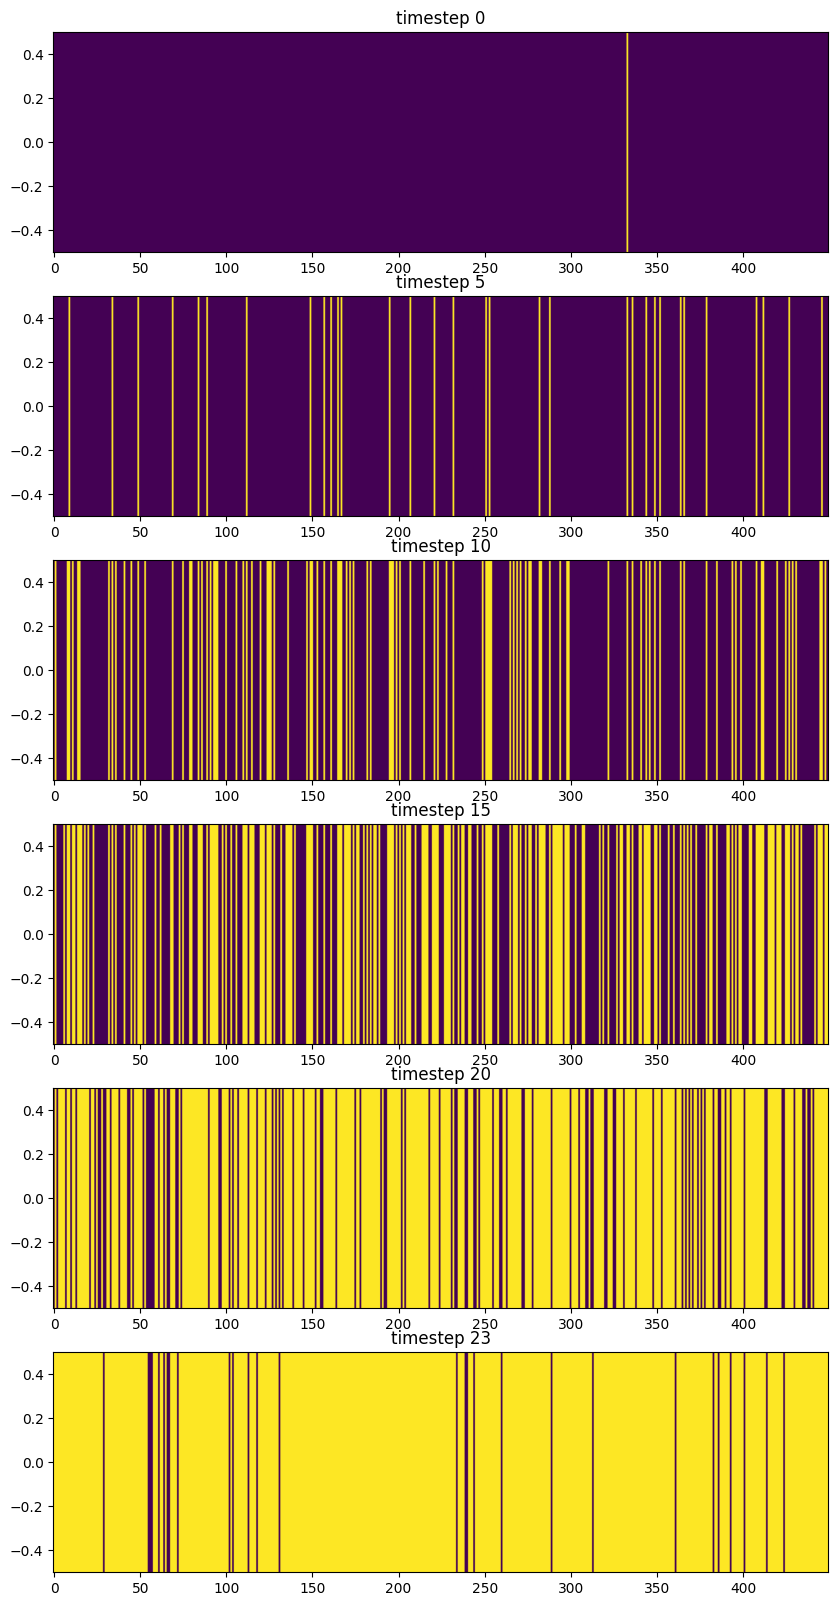

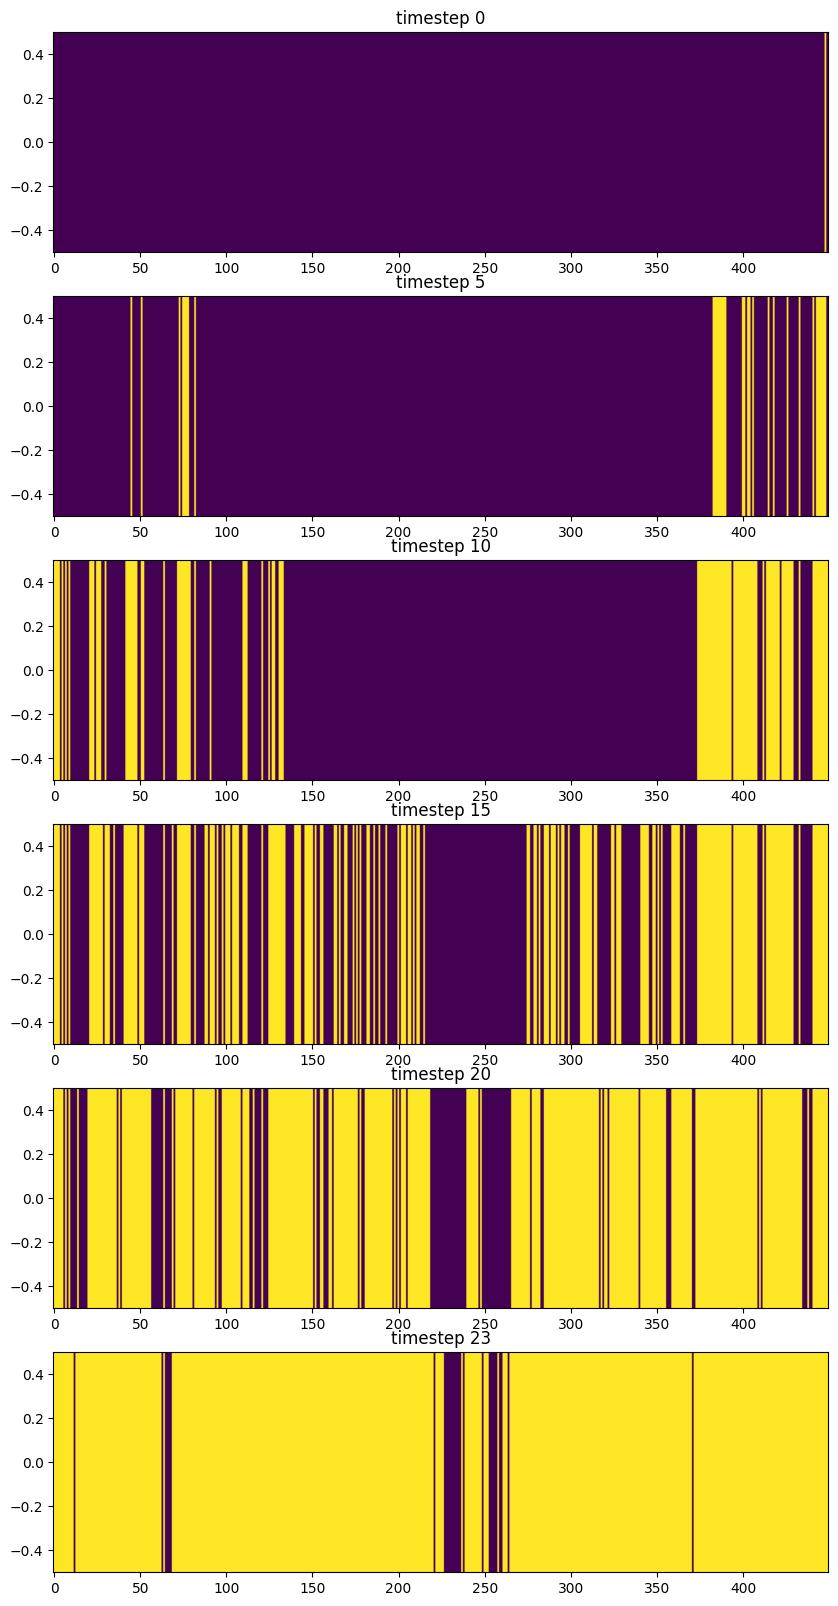

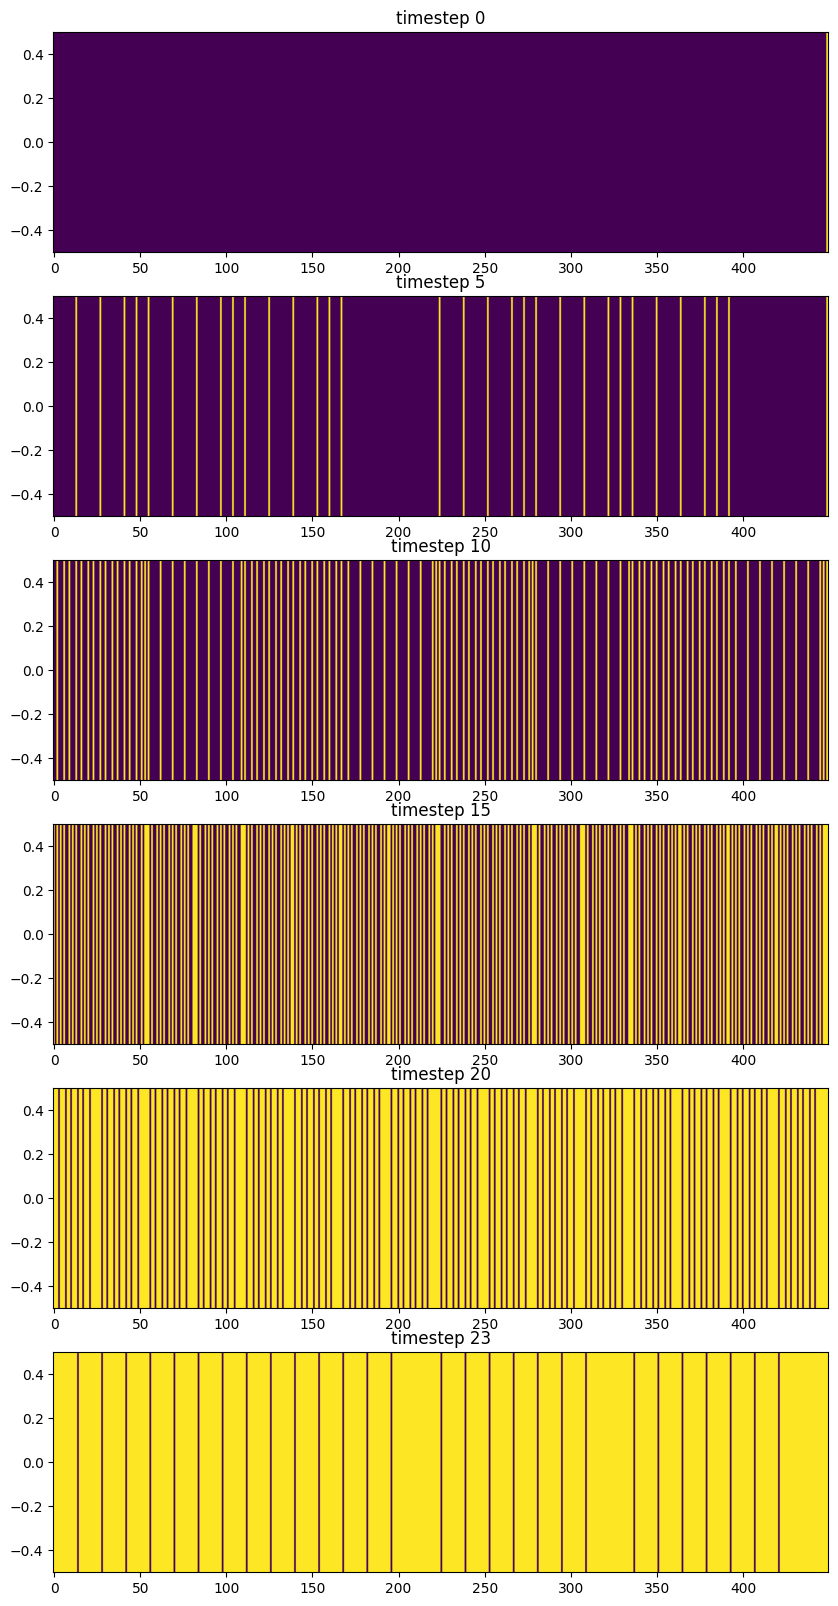

In [19]:
import matplotlib.pyplot as plt
import numpy

def plot_masked_indices(masked_indices_list, seq_len):
    masked_indices_list = [i[0] for i in masked_indices_list]
    logits = numpy.ones(seq_len)
    logits_list = [logits.copy() for _ in range(len(masked_indices_list))]
    for i in range(len(masked_indices_list)):
        # print(len(masked_indices_list[i]))
        for j in range(len(masked_indices_list[i])):
            logits_list[i][masked_indices_list[i][j]] = 0
    # for i in range(len(logits_list)):
    #     print(f"timestep {i}: {logits_list[i]}")

    step = 5

    # logits_list = [i.reshape(9, 690) for i in logits_list]
    logits_list = [i.reshape(1, seq_len) for i in logits_list]
    fig, axes = plt.subplots(len(logits_list) // step + 2, 1, figsize=(10, 20))
    for i in range(0, len(logits_list)+2, 5):
        idx = i // step
        i = min(i, len(logits_list)-1)
        axes[idx].imshow(logits_list[i], aspect='auto', cmap='viridis', origin='lower')
        axes[idx].set_title(f"timestep {i}")
    plt.show()

plot_masked_indices(mask_indices_list_gumble, int(target_len * 50))
plot_masked_indices(mask_indices_list_no_gumble, int(target_len * 50))
plot_masked_indices(mask_indices_list_halton, int(target_len * 50))

## Speed change

In [12]:
prompt_wav_path = "./models/tts/maskgct/wav/prompt.wav"
prompt_text = " We do not break. We never give in. We never back down."
target_text = "In this paper, we introduce MaskGCT, a fully non-autoregressive TTS model that eliminates the need for explicit alignment information between text and speech supervision."

# Specify the target duration (in seconds). If target_len = None, we use a simple rule to predict the target duration.
target_len = 12 # Make it faster

recovered_audio = maskgct_inference(
    prompt_wav_path,
    prompt_text,
    target_text,
    language="en",
    target_language="en",
    target_len=target_len
)

Audio(recovered_audio, rate=24000)

predict semantic shape torch.Size([1, 600])


## Cross-language generation

In [14]:
prompt_wav_path = "./models/tts/maskgct/wav/prompt.wav"
prompt_text = " We do not break. We never give in. We never back down."
target_text = "在本文中，我们介绍了 MaskGCT，这是一种完全非自回归 TTS 模型，它不需要文本和语音监督之间的明确对齐信息。"

# Specify the target duration (in seconds). If target_len = None, we use a simple rule to predict the target duration.
target_len = None

recovered_audio = maskgct_inference(
    prompt_wav_path,
    prompt_text,
    target_text,
    language="en",
    target_language="zh", # use ISO 639-1 code, support: en, zh, ja, de, fr, ko
    target_len=target_len
)

Audio(recovered_audio, rate=24000)

predict semantic shape torch.Size([1, 644])
